In [82]:
#This times each cell being computed
!pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 4.84 s (started: 2023-08-29 02:03:24 +00:00)


In [83]:
#Timing check code block, due to colab issuing resources quite randomly
res = 0
for i in range(10000000):
  res += i
print("Should be around 1.25 seconds")

Should be around 1.25 seconds
time: 2.43 s (started: 2023-08-29 02:03:29 +00:00)


In [84]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import torch
import matplotlib.pyplot as plt

time: 455 µs (started: 2023-08-29 02:03:32 +00:00)


In [85]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and being used")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead")

GPU is available and being used
time: 1.01 ms (started: 2023-08-29 02:03:32 +00:00)


In [86]:
#Downloading the dataset
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

time: 55.3 ms (started: 2023-08-29 02:03:32 +00:00)


In [87]:
n_samples, height, width = lfw_people.images.shape
X = torch.from_numpy(lfw_people.data).to(device)
n_features = X.shape[1]

#Fetching the label or target
y = torch.from_numpy(lfw_people.target).to(device)
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
time: 3.35 ms (started: 2023-08-29 02:03:32 +00:00)


In [88]:
# Split into a training set and a test set using a stratified k fold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_train.to(device)
X_test.to(device)
y_train.to(device)
y_test.to(device)

# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print(type(X), type(X_train), type(y_train), type(y_test))

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
time: 3.12 ms (started: 2023-08-29 02:03:32 +00:00)


In [89]:
#Centering the data
mean = torch.mean(X)  #From the notebook given they compute the mean from X_train, isn`t this wrong? Therefore I use X
X_train -= mean
X_test -= mean

#Eigen decomposition
U, S, Vh = torch.linalg.svd(X_train, full_matrices=False)

components = Vh[:n_components]

eigenfaces = components.reshape((n_components, height, width))

time: 267 ms (started: 2023-08-29 02:03:32 +00:00)


In [90]:
X_transformed = torch.matmul(X_train, components.T)

print(X_transformed.is_cuda)
print(X_transformed.shape)
X_test_transformed = torch.matmul(X_test, components.T)
X_test_transformed.shape

True
torch.Size([966, 150])


torch.Size([322, 150])

time: 6.26 ms (started: 2023-08-29 02:03:32 +00:00)


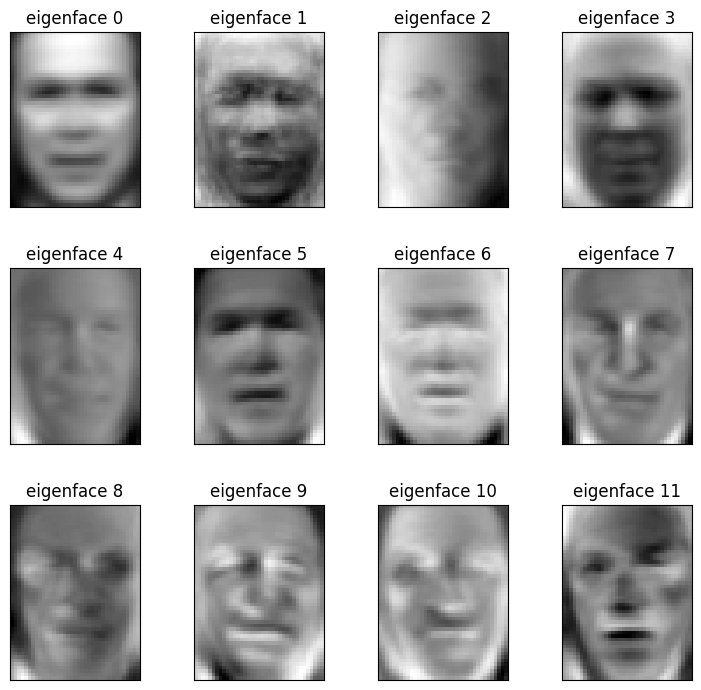

time: 818 ms (started: 2023-08-29 02:05:38 +00:00)


In [92]:
# Qualitative evaluation of the predictions using matplotlib
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
  """Helper function to plot a gallery of portraits"""
  plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
  plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
  for i in range(n_row * n_col):
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
    plt.title(titles[i], size=12)
    plt.xticks(())
    plt.yticks(())

eigenfaces_cpu = eigenfaces.cpu()
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces_cpu.shape[0])]
plot_gallery(eigenfaces_cpu, eigenface_titles, height, width)

torch.Size([966])


TypeError: ignored

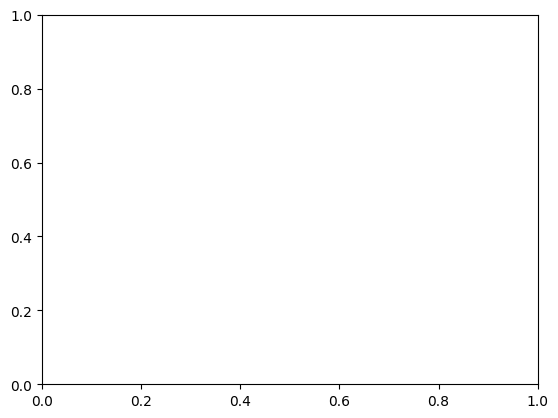

time: 193 ms (started: 2023-08-29 02:09:10 +00:00)


In [96]:
#Evaluating performance of the dimensionality reduction using a compactness plot
explained_variance = (S ** 2) / (n_samples - 1)

explained_variance_cpu = explained_variance.cpu()

total_var = explained_variance.sum()
explained_variance_ratio = explained_variance / total_var
ratio_cumsum = torch.cumsum(explained_variance_ratio, dim=0)
print(ratio_cumsum.shape)
eigenvalueCount = np.arange(n_components)
plt.plot(eigenvalueCount, ratio_cumsum[:n_components])
plt.title('Compactness')
plt.show()

In [ ]:
#Using the PCA face-space as features to build a random forest classifer of the original faces
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

estimator = RandomForestClassifier(n_estimators=150, max_depth=15, max_features=150)
estimator.fit(X_transformed, y_train)

In [ ]:
predictions = estimator.predict(X_test_transformed)
correct = predictions==y_test
total_test = len(X_test_transformed)
#print("Gnd Truth:", y_test)
print("Total Testing", total_test)
print("Predictions", predictions)
print("Which Correct:",correct)
print("Total Correct:",np.sum(correct))
print("Accuracy:",np.sum(correct)/total_test)
print(classification_report(y_test, predictions, target_names=target_names))
